In [43]:
!conda install -c conda-forge -y plotnine


Solving environment: done

## Package Plan ##

  environment location: /Users/joeyyap/opt/anaconda3/envs/scraper

  added / updated specs:
    - plotnine


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    descartes-1.1.0            |             py_4           7 KB  conda-forge
    mizani-0.7.3               |     pyhd8ed1ab_0          53 KB  conda-forge
    palettable-3.3.0           |             py_0          86 KB  conda-forge
    patsy-0.5.1                |             py_0         187 KB  conda-forge
    plotnine-0.8.0             |     pyhd8ed1ab_0         3.8 MB  conda-forge
    statsmodels-0.12.2         |   py39h329c335_0        10.6 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        14.7 MB

The following NEW packages will be INSTALLED:

  descartes          conda-forge/noarch::descartes-1.1

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line

## Crime data for Malaysia 2015-2019

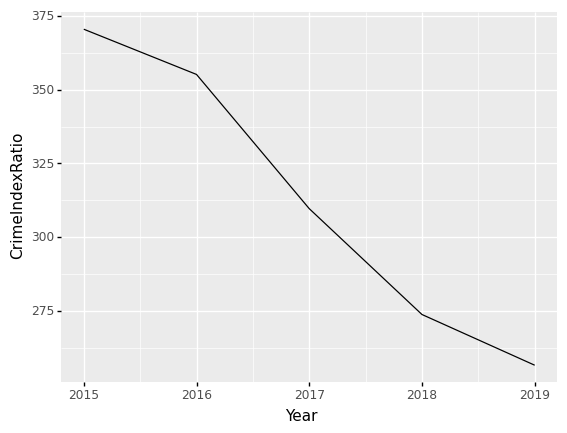

<ggplot: (307191546)>

In [123]:
#Read crime data
df = pd.read_csv("crimeindex.csv")

#Change to year
df['Year'] = pd.to_datetime(df['Year'], format = "%Y")
df['Year'] = df.Year.dt.year

# Visualise Malaysia CIR only
ggplot(df[df['State']=='Malaysia']) + aes(x='Year', y = 'CrimeIndexRatio') + geom_line()

In [124]:
df_country = df[df['State']=='Malaysia']
countrycirvalues = df_country.CrimeIndexRatio.values.tolist()
crimeyear = df_country.Year.tolist()

## Crime Index Ratio for 2019, by state

In [125]:
#Get latest crimeindexratio 2019
df2 = df[df['Year']==2019]
df2 = df2.sort_values(by='CrimeIndexRatio', ascending = False)
df2_states = df2.State.values.tolist()
df2_cirvalues = df2.CrimeIndexRatio.values.tolist()

In [126]:
df2_states

['W.P. Kuala Lumpur',
 'Selangor',
 'Negeri Sembilan',
 'Pulau Pinang',
 'Melaka',
 'Johor',
 'Kedah',
 'Malaysia',
 'Sarawak',
 'Perlis',
 'Perak',
 'Pahang',
 'Kelantan',
 'Terengganu',
 'Sabah']

## Regress crime index ratio on unemployment rates and cpi
### Demean manually to account for fixed entity effects.
1. Fixed entity effects are are entity factors that are time-invariant.
2. Each state might have unique time-invariant factors that should be accounted for.
3. Using fixed entity effects allows us to have a different intercept for each state.

In [127]:
#Get unemployment rates and cpi

df_ue = pd.read_csv("ue_ts.csv")
df_cpi = pd.read_csv("cpi.csv")

In [130]:
#Merge dfs with unemployment dataset
df = df.merge(df_ue, how = "left", on = ['Year', 'State'])
df = df.merge(df_cpi, how="left", on=['Year', 'State'])

In [132]:
#Check correlations with unemployment rate
df.corr()

,Year,CrimeIndexRatio,CrimeIndex,Population,UnemploymentRate
Year,1.000000,-0.276723,-0.068536,0.008558,0.024046
CrimeIndexRatio,-0.276723,1.000000,0.163515,0.017267,-0.355086
CrimeIndex,-0.068536,0.163515,1.000000,0.976629,0.024586
Population,0.008558,0.017267,0.976629,1.000000,0.091104
UnemploymentRate,0.024046,-0.355086,0.024586,0.091104,1.000000


1. CIR has been falling in recent years
2. Rise in population associated with rise in CIR
3. Unemployment rate negatively related to CIR: As ue increases, CIR falls. No suggestion of CIR rising with ue.
4. Could be because we have not grouped by states.

In [184]:
df_demean = df.copy()

In [186]:
#Get CIR, unemployment rate and CPI means by state
df_demean['Mean_CrimeIndexRatio_byState'] = df_demean.groupby('State').CrimeIndexRatio.transform(np.mean)
df_demean['Mean_UnemploymentRate_byState'] = df_demean.groupby('State').UnemploymentRate.transform(np.mean)
df_demean['Mean_CPI_byState'] = df_demean.groupby('State').CPI.transform(np.mean)

In [187]:
#Get demeaned CIR and unemployment rate
df_demean['CrimeIndexRatio'] = df_demean['CrimeIndexRatio'] - df_demean['Mean_CrimeIndexRatio_byState']
df_demean['UnemploymentRate'] = df_demean['UnemploymentRate'] - df_demean['Mean_UnemploymentRate_byState']
df_demean['CPI'] = df_demean['CPI'] - df_demean['Mean_CPI_byState']

In [188]:
df_demean

,State,Year,CrimeIndexRatio,CrimeIndex,Population,UnemploymentRate,CPI,Mean_CrimeIndexRatio_byState,Mean_UnemploymentRate_byState,Mean_CPI_byState
0,Malaysia,2015,57.348,115544,31186100,-0.20,-5.14,313.152,3.30,117.94
1,Malaysia,2016,42.018,112354,31633500,0.10,-2.74,313.152,3.30,117.94
2,Malaysia,2017,-3.472,99169,32022600,0.10,1.56,313.152,3.30,117.94
3,Malaysia,2018,-39.352,88662,32382300,0.00,2.76,313.152,3.30,117.94
4,Malaysia,2019,-56.542,83456,32523000,0.00,3.56,313.152,3.30,117.94
...,...,...,...,...,...,...,...,...,...,...
70,W.P. Kuala Lumpur,2015,112.946,15946,1863400,0.36,-6.04,742.804,2.94,118.44
71,W.P. Kuala Lumpur,2016,163.716,16989,1874100,0.36,-2.94,742.804,2.94,118.44
72,W.P. Kuala Lumpur,2017,-25.944,13482,1880700,0.16,1.36,742.804,2.94,118.44
73,W.P. Kuala Lumpur,2018,-100.214,12127,1887200,-0.54,3.06,742.804,2.94,118.44


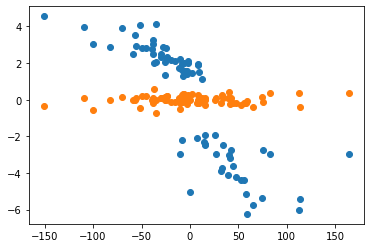

In [210]:
#Check if independent vars are linearly correlated with CIR

#Crime index ratio is linearly correlate with CPI and Unemployment rate after demeaning
plt.scatter(df_demean['CrimeIndexRatio'], df_demean['CPI']) 
#blue: negative corr

plt.scatter(df_demean['CrimeIndexRatio'], df_demean['UnemploymentRate']) 
#orange: positive corr, flattened because of y-scale

In [199]:
#Check how unemployment rates and CPI affects crime index ratio
import statsmodels.api as sm

model = sm.OLS.from_formula('CrimeIndexRatio ~ CPI + UnemploymentRate', df_demean)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        CrimeIndexRatio   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     94.21
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           7.93e-21
Time:                        22:29:09   Log-Likelihood:                -352.89
No. Observations:                  75   AIC:                             711.8
Df Residuals:                      72   BIC:                             718.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.665e-15      3.152  

1. Coefficients of CPI and UnemploymentRate are highly significant.
2. CPI is negatively correlated with CrimeIndexRatio: 1 unit increase in CPI is associated with a fall of 13 units in CIR.
3. Suggesting that perhaps inflation is a sign of a growing economy, thus accompanied by lower crime rates.
4. UnemploymentRate is positively correlated with CIR: 1 unit increase in unemployment rate is associated with an increase of 42 units in CIR.

### The results suggest that higher crime rates are usually accompanied by higher unemployment rates and lower inflation (slower economic growth).

### Include time fixed effects with linearmodels library
1. Each year may have unique factors that affect all the states in a similar way. E.g. high oil prices.
2. Accounting for time fixed effects allows us to take those factors into consideration.

In [279]:
#Try with linearmodels library
!conda install -c conda-forge -y linearmodels

Solving environment: done

## Package Plan ##

  environment location: /Users/joeyyap/opt/anaconda3/envs/scraper

  added / updated specs:
    - linearmodels


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    linearmodels-4.24          |   py39h9fcab8e_1         1.7 MB  conda-forge
    mypy_extensions-0.4.3      |   py39h6e9494a_3          10 KB  conda-forge
    property-cached-1.6.4      |             py_0           9 KB  conda-forge
    property_cached-1.6.4      |                0           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.7 MB

The following NEW packages will be INSTALLED:

  linearmodels       conda-forge/osx-64::linearmodels-4.24-py39h9fcab8e_1
  mypy_extensions    conda-forge/osx-64::mypy_extensions-0.4.3-py39h6e9494a_3
  property-cached    conda-forge/noarch::property-cach

In [281]:
#Set entity index to State, and time index to Year
df = df.set_index(['State','Year'])
df

CrimeIndexRatio  CrimeIndex  Population  \
State             Year                                            
Malaysia          2015           370.50      115544    31186100   
                  2016           355.17      112354    31633500   
                  2017           309.68       99169    32022600   
                  2018           273.80       88662    32382300   
                  2019           256.61       83456    32523000   
...                                 ...         ...         ...   
W.P. Kuala Lumpur 2015           855.75       15946     1863400   
                  2016           906.52       16989     1874100   
                  2017           716.86       13482     1880700   
                  2018           642.59       12127     1887200   
                  2019           592.30       11172     1886200   

                        UnemploymentRate    CPI  
State             Year                           
Malaysia          2015               3.1  112.8  
                  2016               3.4  115.2  
                  2017               3.4  119.5  
                  2018               3.3  120.7  
                  2019               3.3  121.5  
...                                  ...    ...  
W.P. Kuala Lumpur 2015               3.3  112.4  
                  2016               3.3  115.5  
                  2017               3.1  119.8  
                  2018               2.4  121.5  
                  2019               2.6  123.0  

[75 rows x 5 columns]

#### Changes to model:
1. We use both entity and time fixed effects.
2. Although some people argue for clustered standard errors, there is no need for that here because we did not select a random cluster of states and are now trying to generalise to all states. We already have all the states, and wider standard errors for generalisation purposes are not needed.
3. Sidenote: clustering standard errors will increase standard errors and increase the p-value, making the coefs statistically insignificant.

In [353]:
from linearmodels import PanelOLS

#Run new model
model2 = PanelOLS.from_formula('CrimeIndexRatio ~ 1 + CPI + UnemploymentRate + EntityEffects +', df)
# results2 = model2.fit(cov_type='clustered', cluster_entity=True)
results2 = model2.fit()

In [354]:
print(results2)

                          PanelOLS Estimation Summary                           
Dep. Variable:        CrimeIndexRatio   R-squared:                        0.7235
Estimator:                   PanelOLS   R-squared (Between):             -0.6663
No. Observations:                  75   R-squared (Within):               0.7235
Date:                Fri, Jul 30 2021   R-squared (Overall):             -0.4944
Time:                        13:03:51   Log-likelihood                   -352.89
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      75.895
Entities:                          15   P-value                           0.0000
Avg Obs:                       5.0000   Distribution:                    F(2,58)
Min Obs:                       5.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             75.895
                            

In [338]:
# get estimated CIR
results2.predict(data=df, effects=True)

predictions
State             Year             
Malaysia          2015   426.564570
                  2016   367.219806
                  2017   247.780536
                  2018   212.008976
                  2019   189.787716
...                             ...
W.P. Kuala Lumpur 2015   442.554542
                  2016   356.447162
                  2017   232.128550
                  2018   167.830672
                  2019   131.045154

[75 rows x 1 columns]

1. The coef for CPI has now increased, and coef of UnemploymentRate has decreased.
2. Suggests that perhaps there were time effects that were not captured in first model.

## Predict Crime Index Ratio for 2020 Q4 and 2021 Q1

In [318]:
#import csv of 2020 and 2021 data
df_new = pd.read_csv("pred_x.csv")

In [319]:
df_new

,Year,State,CPI,UnemploymentRate
0,2020,Johor,123.20,3.9
1,2021,Johor,125.70,3.9
2,2020,Kedah,116.80,4.0
3,2021,Kedah,119.40,3.6
4,2020,Kelantan,119.00,4.1
5,2021,Kelantan,121.83,4.4
6,2020,Malaysia,120.30,4.8
7,2021,Malaysia,122.50,4.8
8,2020,Melaka,118.00,3.7
9,2021,Melaka,120.33,3.6


In [ ]:
df_new = df_new.set_index(['State','Year'])

In [357]:
predCIR = results2.predict(data=df_new)

In [358]:
predCIR.head(30)

predictions
State             Year             
Johor             2020   255.890523
                  2021   221.431968
Kedah             2020   348.300066
                  2021   295.680598
Kelantan          2020   322.172181
                  2021   295.752025
Malaysia          2020   333.623232
                  2021   303.299704
Melaka            2020   319.173031
                  2021   282.862015
Negeri Sembilan   2020   305.692691
                  2021   247.499237
Pahang            2020   306.525487
                  2021   280.932336
Perak             2020   397.501092
                  2021   349.077267
Perlis            2020   394.452138
                  2021   367.006526
Pulau Pinang      2020   259.490814
                  2021   220.362498
Sabah             2020   588.042039
                  2021   586.966779
Sarawak           2020   399.601809
                  2021   381.804593
Selangor          2020   286.991252
                  2021   256.667723
Terengganu        2020   360.705146
                  2021   309.524636
W.P. Kuala Lumpur 2020   306.117005
                  2021   282.685187

In [379]:
df.query('State=Malaysia')

ValueError: cannot assign without a target object